Using Galerkin Spectral method to find numerical solution to Poisson equation with RHS sin(pi*x)

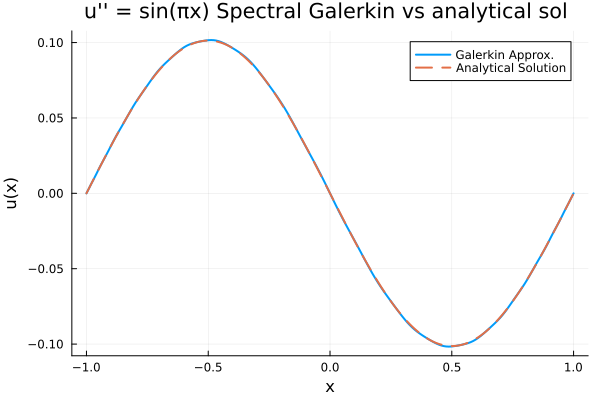

In [48]:
using LinearAlgebra
using Plots

N = 42
x = cos.(π * (0:N) / N) # Nodes

# Chebyshev-T polynomial, T_k(x)
function T(k, x)
    return cos.(k * acos.(x))
end

# RHS of poisson eqn e.g.
f(x) = sin(π*x)

# Modified basis function so that boundary conds are satisfied
function phi_mod(k,x)
    return (1 .- x.^2) .* T(k, x)
end

# Second derivative via central differences
function second_derivative(y, x)
    n = length(x)
    d2y = zeros(n)
    for i in 2:n-1
        h1 = x[i] - x[i-1]
        h2 = x[i+1] - x[i]
        d2y[i] = 2 * ((y[i+1] - y[i]) / h2 - (y[i] - y[i-1]) / h1) / (h1 + h2)
    end

    d2y[1] = d2y[2]
    d2y[end] = d2y[end-1]

    return d2y
end

# Assemble linear system Av=b
A = zeros(N+1, N+1)
b = zeros(N+1)

ϕ = [phi_mod(k, x) for k in 0:N]  # modified phi evaluated at the nodes

for j in 1:N+1
    b[j] = dot([f(a) for a in x], ϕ[j])  # Inner product

    # Within j loop start k loop for matrix A
    for k in 1:N+1
        d2ϕ_k = second_derivative(ϕ[k], x)
        A[j, k] = dot(d2ϕ_k, ϕ[j])         # Galerkin matrix entry
    end
end

v = A \ b

# Construct approximate solution on a dense grid
x_dense = LinRange(-1, 1, 200)
ϕ_dense = [(1 .- x_dense.^2) .* T(k, x_dense) for k in 0:N]
u_approx = reduce(+, (v[k+1] .* ϕ_dense[k+1] for k in 0:N))
u_true = -sin.(π .* x_dense) ./ π^2

# Plots
plot(x_dense, u_approx, label="Galerkin Approx.", lw=2, grid=true)
plot!(x_dense, u_true, label="Analytical Solution", lw=2, ls=:dash)
title!("u'' = sin(πx) Spectral Galerkin vs analytical sol ")
xlabel!("x")
ylabel!("u(x)")

# I get weird oscillations when setting N=40 or 41 for some reason I do not understand
